In [1]:
import pandas as pd
import numpy as np
import sqlite3
import gspread
import scrapbook as sb

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.dates import date2num, DateFormatter
from pandas.plotting import scatter_matrix

plt.style.use('ggplot')
plt.tight_layout()
plt.rcParams['figure.figsize'] = [20, 20]

%matplotlib inline

/Users/cathy/opt/anaconda3/envs/mfe-preprogram/lib/python3.8/site-packages/papermill/iorw.py:50: FutureWarning: pyarrow.HadoopFileSystem is deprecated as of 2.0.0, please use pyarrow.fs.HadoopFileSystem instead.
  from pyarrow import HadoopFileSystem


In [2]:
def hourly_return(df):
    df = df.close/df.close.shift(1) -1
    return df

In [3]:
def vol_ohlc(df, lookback=10):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

In [4]:
def max_drawdown(df):
    peak = df['close'].cummax()
    print(peak)
    hourly_dd = df['close']/peak -1
    print(hourly_dd)
    mdd = hourly_dd.cummin()
    return mdd

In [5]:
def series_plot(data, title, ax=None):
    data.plot(ax=ax)
    ax.set_title(title)
    
    start_of_days = data.between_time('00:00:00', '00:00:00').index.to_list()
    end_of_days = start_of_days[1:] + [data.index[-1]]
    colors = iter(cm.rainbow(np.linspace(0, 1, len(start_of_days))))
    
    for x, y in zip(start_of_days, end_of_days):
        color = next(colors)
        ax.axvspan(x, y, color=color, alpha=0.1)

In [6]:
token = 'BTC'
from_date = '2021-11-05'
to_date = '2021-11-12'
connection_string = 'sqlite:///../../../Lectures/Lecture 4/data/data.db'

In [7]:
# Parameters
from_date = "2021-12-05 00:00:00"
to_date = "2021-12-12 00:00:00"
token = "CRV"
connection_string = "sqlite:///../../../Lectures/Lecture 4/data/data.db"


In [8]:
prices = pd.read_sql(f'''
SELECT 
    * 
FROM ohlc 
WHERE 
    token = '{token}'
    AND ts >= '{from_date}'
    AND ts < '{to_date}'
''', connection_string)
prices['ts'] = pd.to_datetime(prices['ts'])

prices.set_index('ts', inplace=True)

In [9]:
prices['hourly_return'] = hourly_return(prices)
prices['hourly_vol_ohlc'] = vol_ohlc(prices)
prices['hourly_max_drawdown'] = max_drawdown(prices)

ts
2021-12-05 00:00:00    3.7552
2021-12-05 01:00:00    3.8526
2021-12-05 02:00:00    3.8526
2021-12-05 03:00:00    3.8526
2021-12-05 04:00:00    3.8728
                        ...  
2021-12-11 19:00:00    4.2038
2021-12-11 20:00:00    4.2038
2021-12-11 21:00:00    4.2038
2021-12-11 22:00:00    4.2038
2021-12-11 23:00:00    4.2038
Name: close, Length: 168, dtype: float64
ts
2021-12-05 00:00:00    0.000000
2021-12-05 01:00:00    0.000000
2021-12-05 02:00:00   -0.005840
2021-12-05 03:00:00   -0.010253
2021-12-05 04:00:00    0.000000
                         ...   
2021-12-11 19:00:00   -0.124602
2021-12-11 20:00:00   -0.138874
2021-12-11 21:00:00   -0.138874
2021-12-11 22:00:00   -0.119844
2021-12-11 23:00:00   -0.126980
Name: close, Length: 168, dtype: float64


In [10]:
%%capture

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

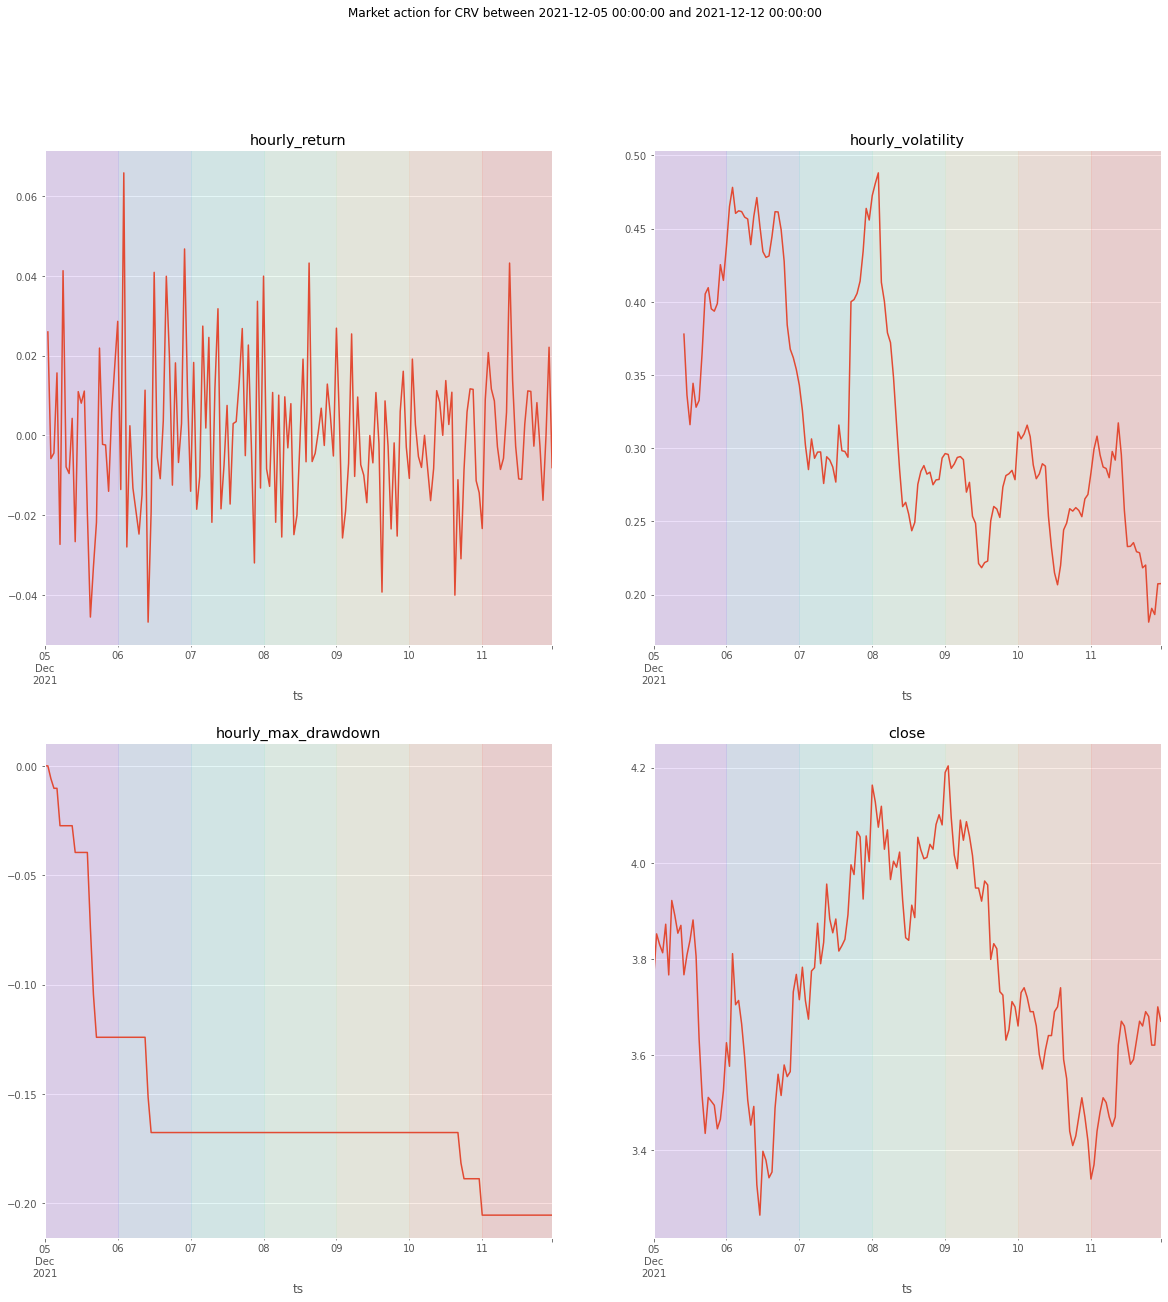

In [11]:
series_plot(prices['hourly_return'], 'hourly_return', ax=ax[0, 0])
series_plot(prices['hourly_vol_ohlc'], 'hourly_volatility', ax=ax[0, 1])
series_plot(prices['hourly_max_drawdown'], 'hourly_max_drawdown', ax=ax[1, 0])
series_plot(prices['close'], 'close', ax=ax[1, 1])
fig.suptitle(f'Market action for {token} between {from_date} and {to_date}')
fig

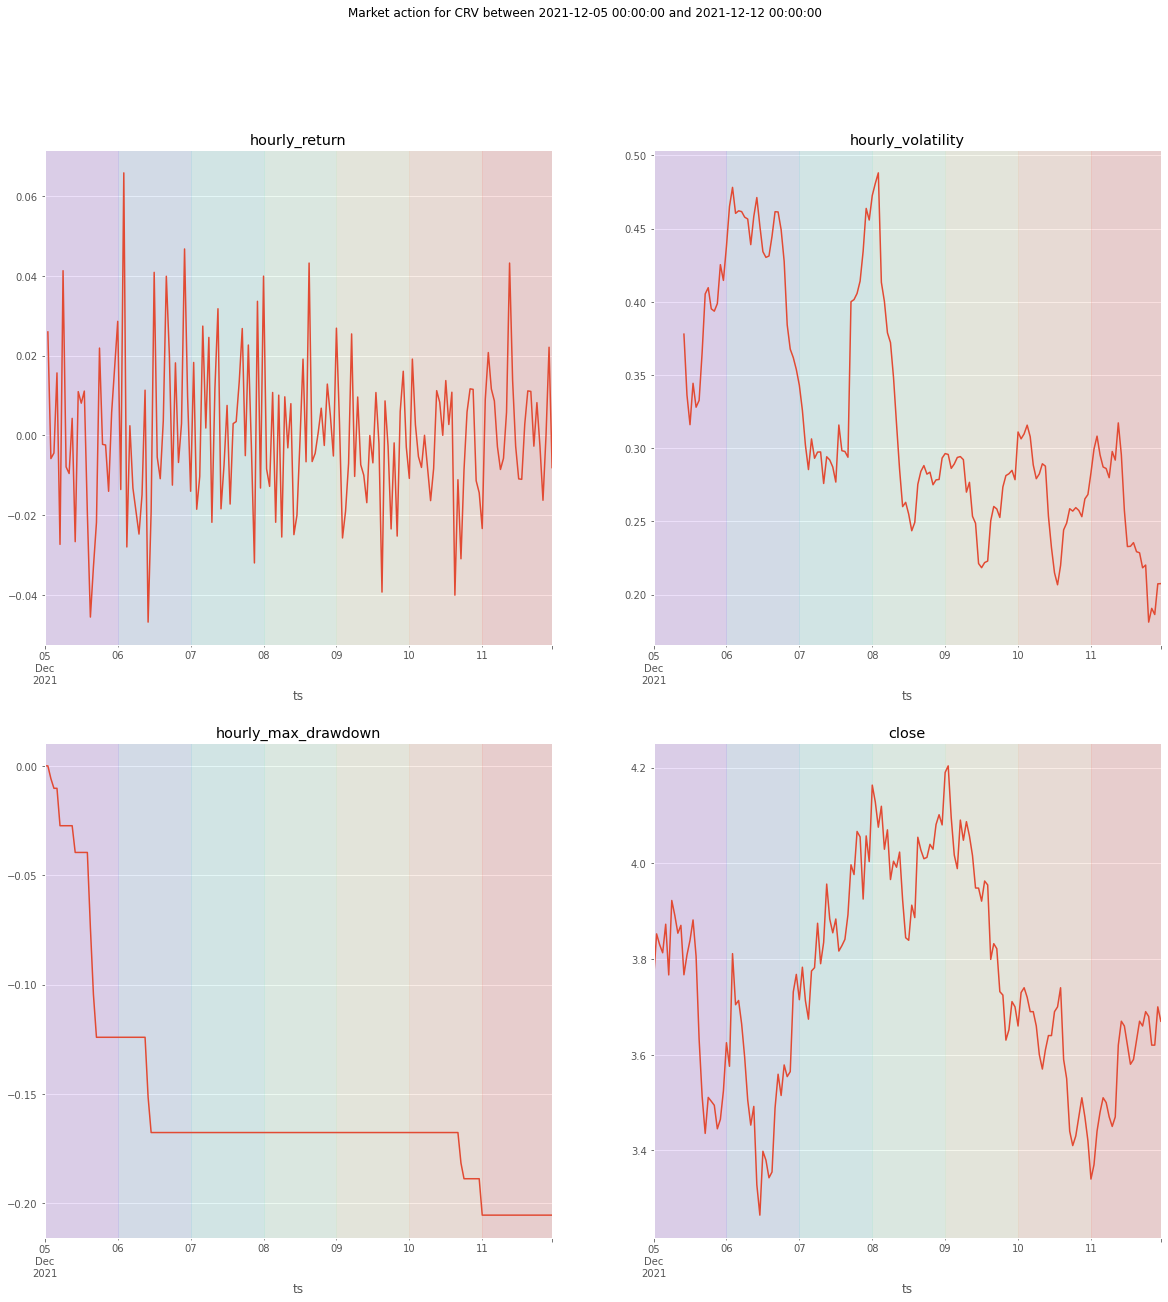

In [12]:
sb.glue('token', token)
sb.glue('from_date', from_date)
sb.glue('to_date', to_date)
sb.glue('prices', prices, encoder='pandas')
sb.glue('summary_plot', fig, encoder='display', display=True)